In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from Data.libraries import utilities, visualization
from Data.autoencoder.libraries import utilities as utilities_autoencoder
import matplotlib.pyplot as plt
import collections
import numpy as np
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, is_valid_linkage
import scipy

In [3]:
currency = 'GBPUSD'
df, df_returns = utilities_autoencoder.get_data()
columns = utilities_autoencoder.get_columns(df_returns, include_timestamp=False)
columns

['AUDUSD_open',
 'AUDUSD_high',
 'AUDUSD_low',
 'AUDUSD_close',
 'CADUSD_open',
 'CADUSD_high',
 'CADUSD_low',
 'CADUSD_close',
 'CHFUSD_open',
 'CHFUSD_high',
 'CHFUSD_low',
 'CHFUSD_close',
 'EURUSD_open',
 'EURUSD_high',
 'EURUSD_low',
 'EURUSD_close',
 'GBPUSD_open',
 'GBPUSD_high',
 'GBPUSD_low',
 'GBPUSD_close',
 'JPYUSD_open',
 'JPYUSD_high',
 'JPYUSD_low',
 'JPYUSD_close',
 'NZDUSD_open',
 'NZDUSD_high',
 'NZDUSD_low',
 'NZDUSD_close',
 'SEKUSD_open',
 'SEKUSD_high',
 'SEKUSD_low',
 'SEKUSD_close']

In [17]:
df.head(3)

,AUDUSD_open,AUDUSD_high,AUDUSD_low,AUDUSD_close,CADUSD_open,CADUSD_high,CADUSD_low,CADUSD_close,CHFUSD_open,CHFUSD_high,CHFUSD_low,CHFUSD_close,EURUSD_open,EURUSD_high,EURUSD_low,EURUSD_close,GBPUSD_open,GBPUSD_high,GBPUSD_low,GBPUSD_close,JPYUSD_open,JPYUSD_high,JPYUSD_low,JPYUSD_close,NZDUSD_open,NZDUSD_high,NZDUSD_low,NZDUSD_close,SEKUSD_open,SEKUSD_high,SEKUSD_low,SEKUSD_close,timestamp
0,0.72815,0.72815,0.72815,0.72815,0.723872,0.723987,0.723778,0.723856,0.99893,0.99898,0.99889,0.99889,1.08669,1.08707,1.08668,1.08707,1.47319,1.47329,1.47293,1.47329,0.008321,0.008321,0.00832,0.00832,0.6827,0.6827,0.68263,0.68266,0.118503,0.11852,0.118503,0.11852,2016-01-01 00:26:00
1,0.72815,0.72815,0.72815,0.72815,0.723872,0.723987,0.723778,0.723856,0.99893,0.99893,0.99842,0.99842,1.08669,1.08707,1.08668,1.08707,1.47319,1.47329,1.47293,1.47329,0.008321,0.008321,0.00832,0.00832,0.6827,0.6827,0.68263,0.68266,0.118503,0.11852,0.118503,0.11852,2016-01-01 00:27:00
2,0.72815,0.72815,0.72815,0.72815,0.723872,0.723987,0.723778,0.723856,0.99893,0.99893,0.99842,0.99842,1.08669,1.08707,1.08668,1.08707,1.47319,1.47329,1.47293,1.47329,0.008321,0.008321,0.00832,0.00832,0.6827,0.6827,0.68263,0.68266,0.118503,0.11852,0.118503,0.11852,2016-01-01 00:49:00


We can see the 8 currencies from the G8. Let's run some preliminary checks.

In [47]:
timestamps = df[['timestamp']]
plt.plot(df.index, timestamps.timestamp)
print('First Date: %s' % timestamps.timestamp.values[0])
print('Last Date:  %s' % timestamps.timestamp.values[-1])
print('# of timestamps: %s' % len(timestamps))

First Date: 2016-01-01T00:26:00.000000000
Last Date:  2016-12-30T21:59:00.000000000
# of timestamps: 375075


Looks like we have all the ticks from 2016, for a grand total of 375075 data points. We have separately checked that all the datapoints for all the currencies are aligned.

In [54]:
timestamps_diff = timestamps.diff().dropna()
timestamps_diff.timestamp = timestamps_diff.timestamp / np.timedelta64(1, 's')
dict(collections.Counter(timestamps_diff.timestamp))

{60.0: 374963,
 120.0: 3,
 180.0: 6,
 240.0: 9,
 300.0: 11,
 360.0: 4,
 540.0: 3,
 600.0: 2,
 660.0: 4,
 720.0: 5,
 900.0: 2,
 1080.0: 1,
 1320.0: 4,
 1920.0: 2,
 2640.0: 1,
 3300.0: 1,
 5220.0: 1,
 169260.0: 1,
 172860.0: 49,
 172980.0: 1,
 176460.0: 1}

We have mostly 60sec differences, with the week ends well visible, and some various other lags.

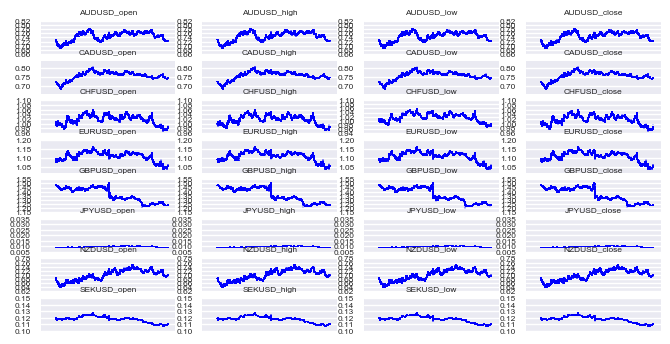

In [15]:
visualization.plot_all_columns(df, columns=columns, drop='timestamp', title='')

Notice the big drop in GBPUSD when Brexit happened.

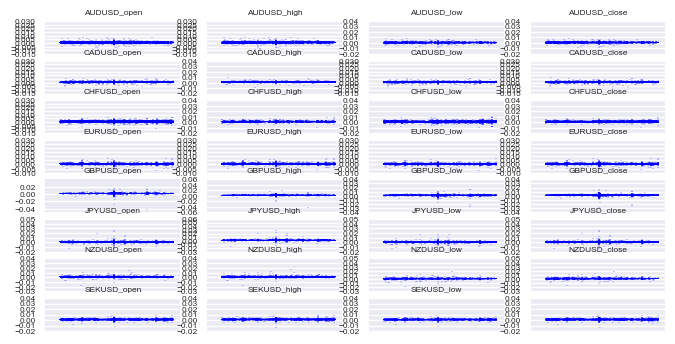

In [16]:
visualization.plot_all_columns(df_returns, columns=columns, drop='timestamp', title='')

Our problematic: 'How much is it possible to compress the most recent 2h time series history'. By that we assume the matrix of the last (2h x 60sec datapoints, 8 currencies x HLOC)=$(2*60, 8*4)$ data points.

Keeping in mind that our autoencoder will have to work either jointly for all pairs, or has to work well across all pairs (in which case the same model will have to be used for each pair).

You mentioned we have 4 possible choices for representing the problem:

1) 1min granularity single pair

2) HLOC granularity single pair

3) 1min granularity all pairs

4) HLOC granularity all pairs

"In 1min granularity, we are only concerned with compressing the time series of close prices, either individually (single pair) or jointly (all pairs). The idea behind joint compression of multiple time series is that mutual information between time series can be regarded as redundancy that might help with the compression. With ohlc granularity, we are trying to capture more information about the time series than 1min snapshots."

Our intuitions are the following:

- We think problem 1) is very different from the others, in the sense that only one series at a time could be used. Therefore the compression can only be done in time space (whereas for the others it can be done across series). While Fourrier transforms would be a natural choice, the same model cannot be used successfully across pairs. We would also be missing out on the information common to all stocks: the so-called market factor (beta) exists, goes as far ago as the CAPM (and granted a Nobel prize to the authors). Because of this, without having access to all spots at the same time, we doubt any model will be able to efficiently detect it. This model would have to learn the features intrinsic to the time series considered, and because the FX spots have very different dynamics, driven by many idiosyncratic factors in addition to the systemic ones, we doubt we could find one model that would work well on each pair.

- For 2) it should be fairly easy to encode HLOC for a given pair, but once again we would miss the ability to compress the market factor across all the pairs.

- It seems then natural to pose the problem as looking at all the pairs simultaneously. The difference between 3) and 4) is less pronounced, and it seems more reasonable that a model working well for 4) would work for 3), as in a sense HLOC provides more information about the distribution of the spot in the last minute. Following this idea, having the expectation (or supposing it to be close to zero), we could use estimators such as Garman Klass to estimate more granular volatility measures, which would give us the first two moments of the distribution. Therefore it seems natural to use HLOC systematically.

Let's have a look more in details at GBPUSD.

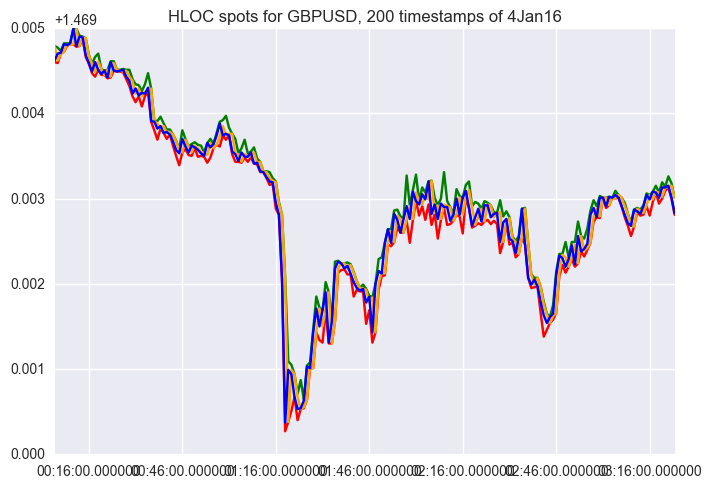

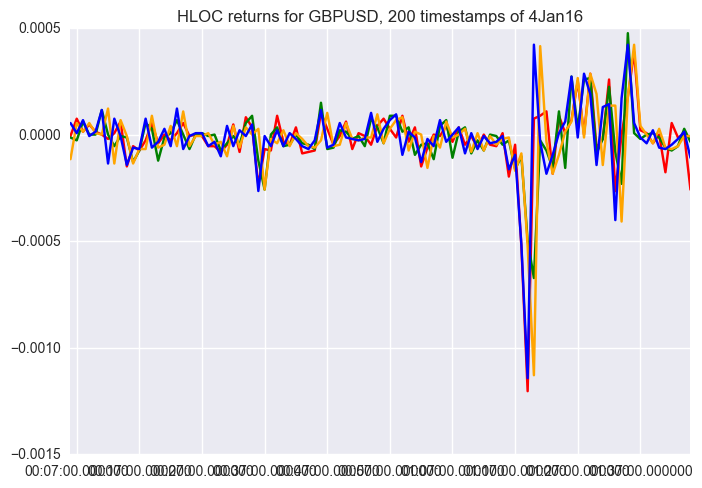

In [18]:
plt.figure(1)
plt.plot(df.timestamp[800:1000,], df[currency + '_low'][800:1000,], color='red')
plt.plot(df.timestamp[800:1000,], df[currency + '_high'][800:1000,], color='green')
plt.plot(df.timestamp[800:1000,], df[currency + '_open'][800:1000,], color='orange')
plt.plot(df.timestamp[800:1000,], df[currency + '_close'][800:1000,], color='blue')
plt.title('HLOC spots for %s, 200 timestamps of 4Jan16' % currency)
plt.show()

plt.figure(2)
plt.plot(df_returns.timestamp[800:900,], df_returns[currency + '_low'][800:900,], color='red')
plt.plot(df_returns.timestamp[800:900,], df_returns[currency + '_high'][800:900,], color='green')
plt.plot(df_returns.timestamp[800:900,], df_returns[currency + '_open'][800:900,], color='orange')
plt.plot(df_returns.timestamp[800:900,], df_returns[currency + '_close'][800:900,], color='blue')
plt.title('HLOC returns for %s, 200 timestamps of 4Jan16' % currency)
plt.show()

While the spots are bounded inside low/high, the returns are not, as one would expect.

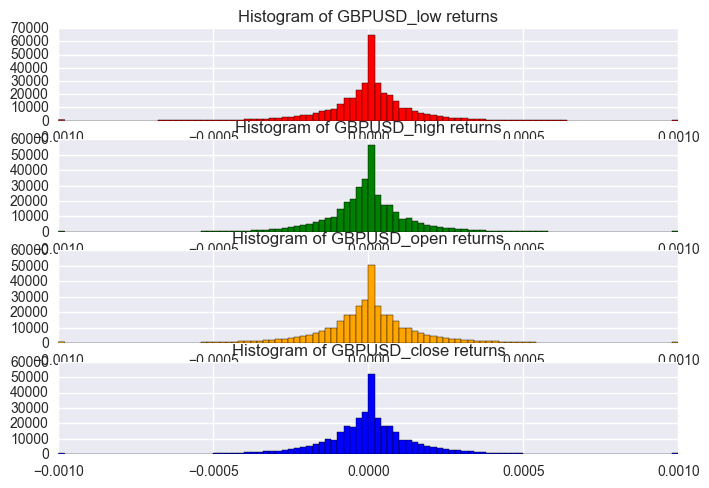

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(411)
ax1.hist(df_returns[currency + '_low'].clip(-0.001, 0.001), bins=100, color='red')
ax1.set_title('Histogram of %s_low returns' % currency)
ax2 = fig.add_subplot(412)
ax2.hist(df_returns[currency + '_high'].clip(-0.001, 0.001), bins=100, color='green')
ax2.set_title('Histogram of %s_high returns' % currency)
ax3 = fig.add_subplot(413)
ax3.hist(df_returns[currency + '_open'].clip(-0.001, 0.001), bins=100, color='orange')
ax3.set_title('Histogram of %s_open returns' % currency)
ax4 = fig.add_subplot(414)
ax4.hist(df_returns[currency + '_close'].clip(-0.001, 0.001), bins=100, color='blue')
ax4.set_title('Histogram of %s_close returns' % currency)
fig.show()
plt.show()

While they are similar, the probability density functions do exhibit different behaviour, in the standard deviation, skews and kurtoses. Let's put some numbers on this.

In [5]:
visualization.describe_df(df_returns)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
AUDUSD_open,375074.0,-3.186183e-08,0.000210,-0.009751,-0.000097,0.0,0.000097,0.006784,-0.728847,84.506241
AUDUSD_high,375074.0,-3.012079e-08,0.000190,-0.009290,-0.000080,0.0,0.000078,0.006479,-0.168162,108.852078
AUDUSD_low,375074.0,-3.201006e-08,0.000192,-0.016973,-0.000078,0.0,0.000080,0.007312,-3.103816,263.821118
AUDUSD_close,375074.0,-3.012079e-08,0.000211,-0.016234,-0.000097,0.0,0.000098,0.006757,-1.617263,164.499966
CADUSD_open,375074.0,7.670748e-08,0.000169,-0.010935,-0.000067,0.0,0.000066,0.005357,-0.798965,93.410938
CADUSD_high,375074.0,7.646287e-08,0.000154,-0.010171,-0.000055,0.0,0.000052,0.009158,0.276083,147.711207
CADUSD_low,375074.0,7.453311e-08,0.000152,-0.010873,-0.000053,0.0,0.000055,0.005022,-1.810988,136.395638
CADUSD_close,375074.0,7.438550e-08,0.000169,-0.010287,-0.000067,0.0,0.000066,0.005725,-0.656282,85.811339
CHFUSD_open,375074.0,-4.723007e-08,0.000256,-0.009965,-0.000100,0.0,0.000100,0.006197,-0.178407,30.894326
CHFUSD_high,375074.0,-4.497390e-08,0.000173,-0.010119,-0.000097,0.0,0.000096,0.007055,0.530138,99.321193


From this very preliminary check, we can see that the crosses have very different statistical properties. Their volatilities vary a lot, as do their skews and kurtoses, both have switching signs. We can see the first signs of macroeconomical events (Brexit on GBPUSD), and some first similarities between crosses of the same geographical regions.

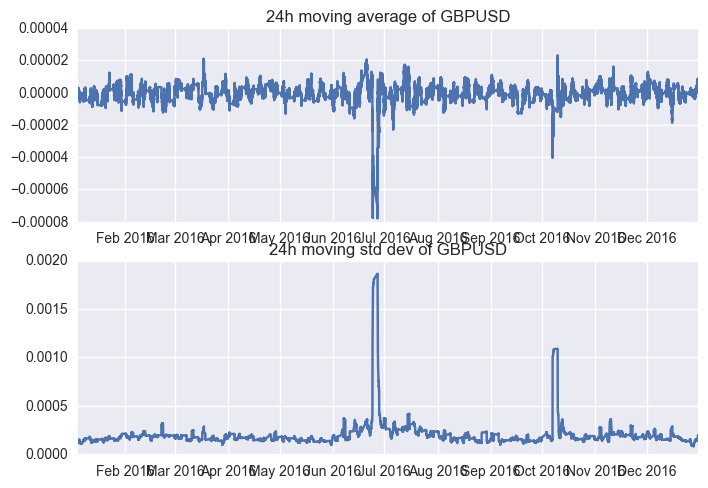

In [13]:
ma_returns = df_returns.set_index('timestamp')[[currency + '_close']].rolling(24*60).mean()
mstd_returns = df_returns.set_index('timestamp')[[currency + '_close']].rolling(24*60).std()

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(ma_returns)
ax1.set_title('24h moving average of %s' % currency)
ax4 = fig.add_subplot(212)
ax4.plot(mstd_returns)
ax4.set_title('24h moving std dev of %s' % currency)
fig.show()
plt.show()

We see some explosive periods, which indicate that as expected, the process is not stationnary. Let's check our next known stylized fact.

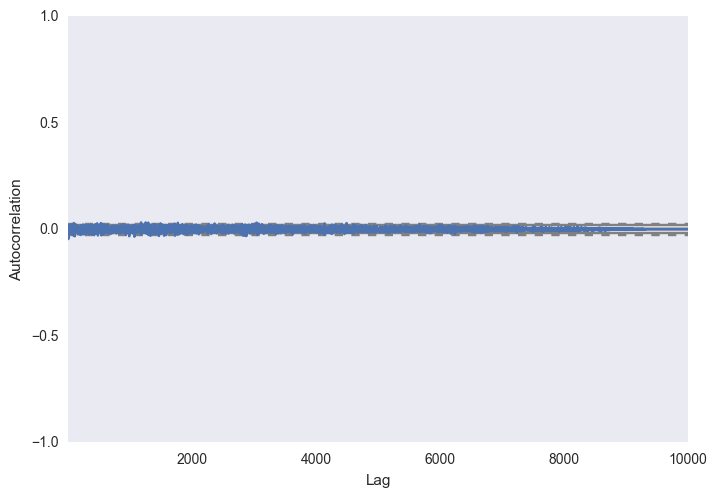

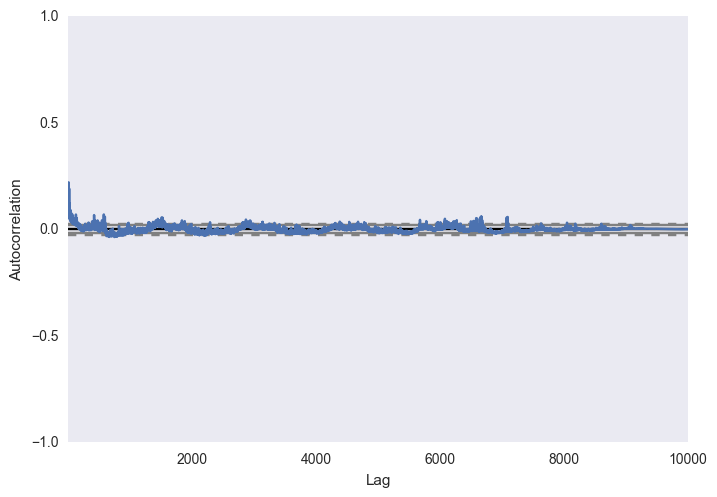

In [15]:
visualization.plot_autocorrelation(df_returns.head(10000), currency + '_close')
visualization.plot_autocorrelation(df_returns.head(10000), currency + '_close', squared=True)

Here we observe the autocorrelation of log-returns (first graph), and squared log-returns (second graph). Let us list the stylized facts we know about volatility:

1) Excess volatility: many empirical studies point out to the fact that it is difficult to justify the observed level of variability in asset returns by variations in “fundamental” economic variables. In particular, the occurrence of large (negative or positive) returns is not always explainable by the arrival of new information on the market. See for example all the work of JP Bouchaud on this (or this video that absolutely wonderful: http://www.dailymotion.com/video/xd1yo1_jean-philippe-bouchaud-des-marches_tech)

2) Heavy tails: the (unconditional) distribution of returns displays a heavy tail with positive excess kurtosis.

3) Absence of autocorrelations in returns: (linear) autocorrelations of asset returns are often insignificant, except for very small intraday time scales (20 minutes) where microstructure effects come into play. If we would zoom the graphs above at the first few ticks, we can see some positive/negative/positive autocorrelation. This might be due to order book effects.

4) Volatility clustering: as noted by Mandelbrot, “large changes tend to be followed by large changes, of either sign, and small changes tend to be followed by small changes.” A quantitative manifestation of this fact is that, while returns themselves are uncorrelated, absolute returns $|r_t|$ or their squares display a positive, significant and slowly decaying autocorrelation function: $corr(|r_t|, |r_{t+τ}|) > 0$ for $τ$ ranging from a few minutes to a several weeks. This is the second graph.

5) Volume/volatility correlation: trading volume is positively correlated with market volatility. Moreover, trading volume and volatility show the same type of “long memory” behavior. Would it make sense to get the volume information for the purpose of autoencoding?

The well known consequence of these results is that when dealing with non-stationnary and autocorrelated time series, many sampling and cross validation techniques should be avoided. K-Fold CV, and any random sampling methods, that break the time continuity, will loose important information. Instead, data from close past timestamps should be exploited (e.g. in the simplest form possible, by looking at historical moving average, and in more complex forms, by using algorithms with memory, e.g. LSTM networks). For the CV itself, we will need to use either sliding and consecutive train/test samples, either an increasing train and sliding test (which is what have just been added to sklearn in TimeSeriesCV). 

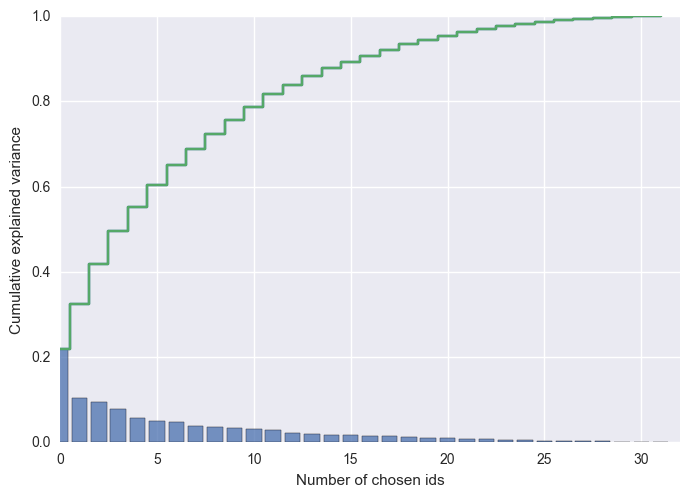

In [28]:
visualization.pca(df_returns.drop('timestamp', axis=1))
plt.show()

We would have expected 8 factors to yield slightly more cumulative explained variance (say ~0.9 instead of ~0.7). This indicates that the information contained in the H/L/O/C are not redundant and will be an important part of the autoencoder. Let us vizualise some correlations.

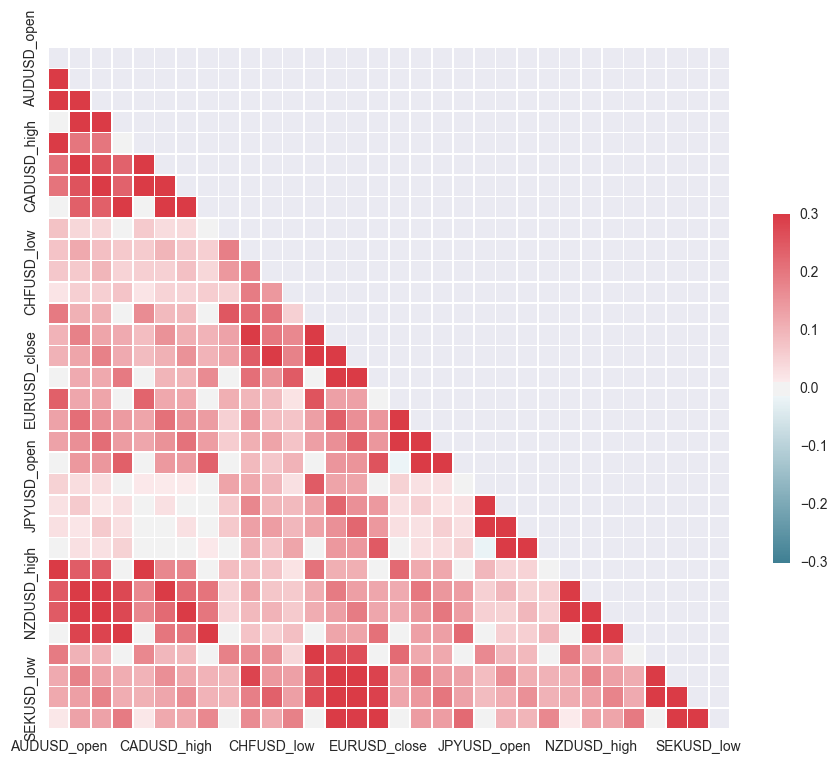

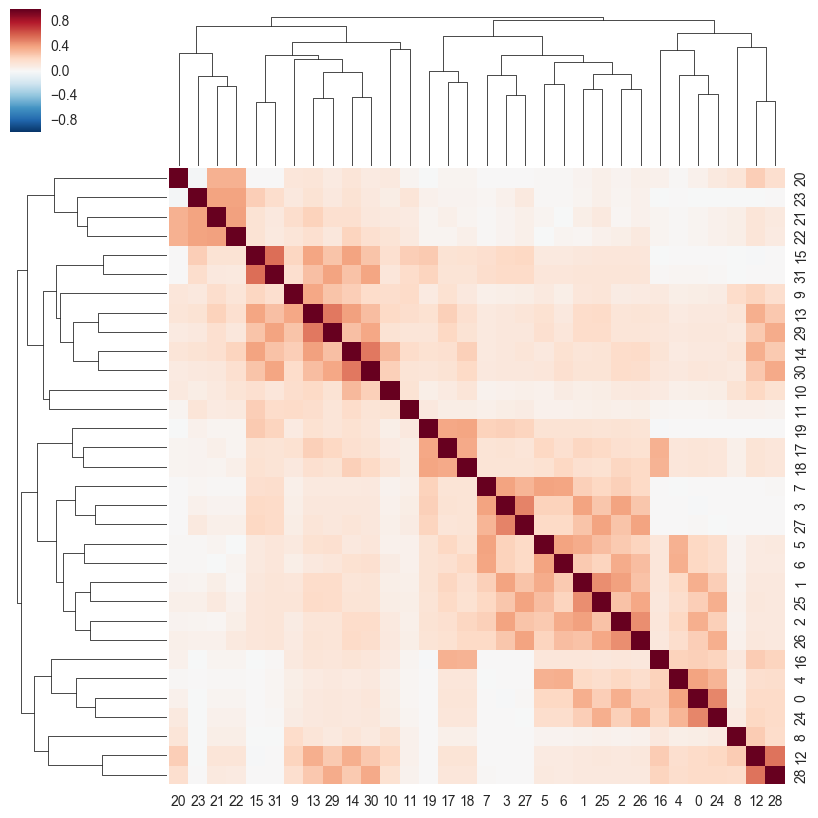

In [4]:
visualization.correlation_matrix(df_returns, method='kendall', last_row=False)
plt.show()

Quite surprisingly, not all the returns of one cross are clustered together using the dendogram. But we still do see the geographical zones emerging: CAD/NZD/AUD, JPY/KRW/SEK, CHF/EUR. 

We used Kendall-Tau's correlation estimator, rather than the regular Pearson's correlation, which can only capture linear dependencies in data. The result using Pearson's correlation estimator slightly differ and show less clear clusters. 

The second point to point out is that our clustering method (the dendogram), used a the correlation as a similarity measure (and constructing a dissimilarity measure from it). There exists plenty of literature on finding appropriate distance measure for time series. The Euclidean distance is well known to fail completely to efficiently detect similar time series (when comparing, e.g. two time translated sinusoids). Correlation is able to capture some interaction, but is not a great measure either. We test some clustering using our preferred method for time series (Dynamic Time Warping), below.

True


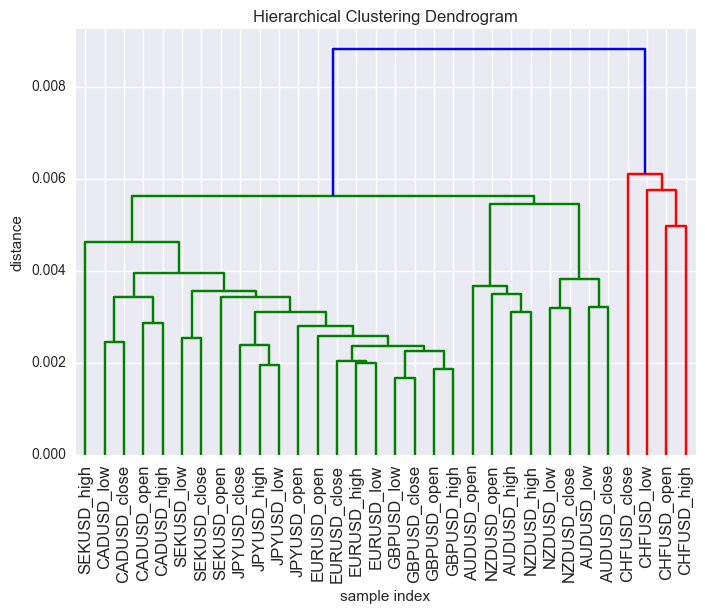

In [5]:
dtw_matrix = utilities.DTW_distance_matrix(df_returns.head(1000).drop('timestamp', axis=1), 1)
dtw_matrix = dtw_matrix.T + dtw_matrix
linkage_matrix = linkage(ssd.squareform(dtw_matrix), method='weighted', metric='euclidean')
print(is_valid_linkage(linkage_matrix))

plt.figure(1)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
scipy.cluster.hierarchy.dendrogram(linkage_matrix, labels=columns, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.show()

Beside confirming the clusters that we estimated above, interesting results can be seen here. Nearly systematically, Open & High are clustered together separately, as are Low & Close. This could indicate some overall trend in the dataset (we only have 1y worth of data, which is smaller than the average macroeconomic cycle). This is somewhat confirmed when looking at GBPUSD, which is clearly trending down (as seen on the graphs at the top), and for which Open/High and Low/Close are the first branches of the tree.

Let us try to fit some kernels to the probability distribution function of our returns, e.g. for GBPUSD.

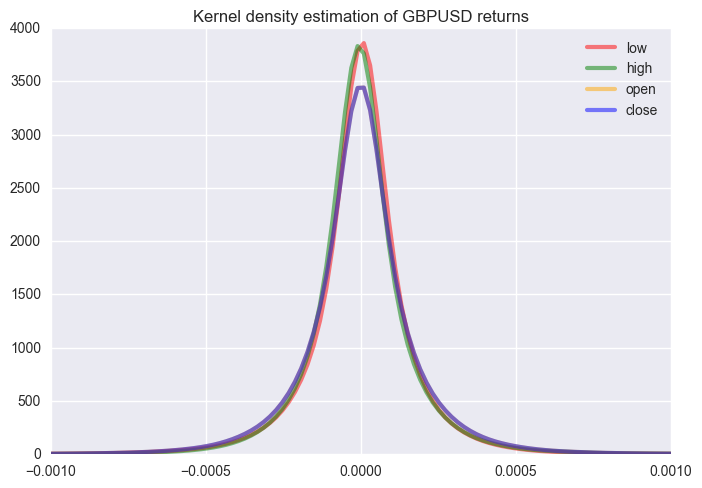

In [19]:
x_grid = np.linspace(-0.001, 0.001, 100)
kde_low = visualization.kde_sklearn(df_returns[currency + '_low'], bandwidth=0.00005, x_grid=x_grid)
kde_high = visualization.kde_sklearn(df_returns[currency + '_high'], bandwidth=0.00005, x_grid=x_grid)
kde_open = visualization.kde_sklearn(df_returns[currency + '_open'], bandwidth=0.00005, x_grid=x_grid)
kde_close = visualization.kde_sklearn(df_returns[currency + '_close'], bandwidth=0.00005, x_grid=x_grid)
fig = plt.figure()
ax = fig.add_subplot(111)
low_plot, = ax.plot(x_grid, kde_low, color='red', alpha=0.5, lw=3, label='low')
high_plot, = ax.plot(x_grid, kde_high, color='green', alpha=0.5, lw=3, label='high')
open_plot, = ax.plot(x_grid, kde_open, color='orange', alpha=0.5, lw=3, label='open')
close_plot, = ax.plot(x_grid, kde_close, color='blue', alpha=0.5, lw=3, label='close')
ax.legend(handles=[low_plot, high_plot, open_plot, close_plot])
ax.set_title('Kernel density estimation of %s returns' % currency)
plt.show()

And the same graph, using a more granular window (and a differnt method):

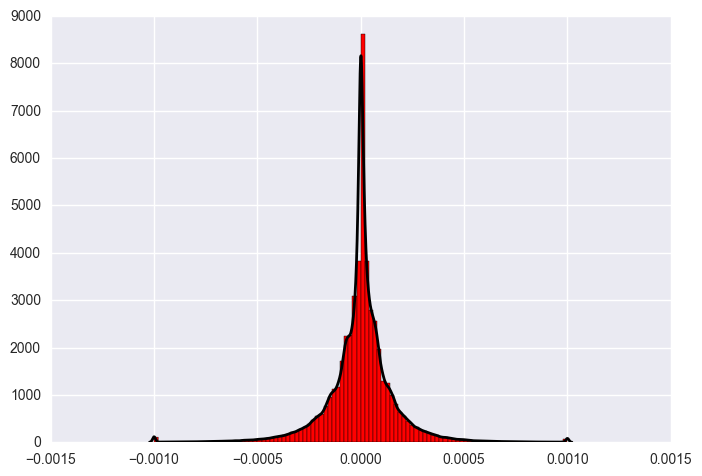

In [22]:
visualization.kde_statsmodel(df_returns[currency + '_low'].clip(-0.001, 0.001))
plt.show()

This example confirms the observation made above, i.e. that H/L/O/C have different distributions, which can be pretty well approximation using very regular Kernel estimation methods.

Lastly, we'll proceed with some simple stationarity test, as a precaution, using the augmented Dickey-Fuller test. While we do not believe wildly in tests generally, they still provide additional datapoints to consider.

In [23]:
visualization.stationarity_test(df[currency + '_close'].head(10000))

ADF Statistic: -0.949013
p-value: 0.771404
Critical Values:
	10%: -2.567
	5%: -2.862
	1%: -3.431


In [24]:
visualization.stationarity_test(df_returns[currency + '_close'].head(10000))

ADF Statistic: -26.849853
p-value: 0.000000
Critical Values:
	10%: -2.567
	5%: -2.862
	1%: -3.431


While spots are obviously (as one could expect) not stationary, this seems to indicate that we can safely work with returns, without having to use additional lag-1 differentiations (which has the additional advantage that returns are very intuitive to us and possess many well-known properties). This test has been done on the first 10000 values (roughly 1 week), which is just enough to state that in this timeframe, and at this timescale, the data remains stationary. It can very well be seen that at longer timescales the data is not stationary. The same result seems to be shared accross all currency returns:

In [26]:
pvalues_returns = visualization.stationarity_test_many(df_returns.head(10000).drop('timestamp', axis=1), return_value='pvalue')
pvalues_returns

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])

This concludes our visualization notebook.